## District median housing price

# 1- Framing the problem

The first question you should ask your boss is what is the end goal of the model, in other words what's the business objective of the model.

Answer: the model output will be fed to another **Machine Learning System** along with other signals. Which will determine whether it's worth investing in a given district or not.
So the model's output (Median Housing Price in a District) is critical, as it directly affects the whole system

The next question is to ask your boss how the current solution looks like and it's performance.

This will give you an idea about what to expect for your model performance.

**supervised, unsupervised or reinforcement Learning ?**

Since we have labeled training examples(meaning that each example comes with expected output - Median Price), it's clearly a supervised learning problem

**Classification or Regression Problem ?**

The target variable is continuous => *Regression problem*, more specifically it's a **multiple regression problem** since we are using multiple features to predict the output.

**Offline(Batch) or Online learning ?**

In **batch learning** the model is not capable for learning incrementally. It must be trained on all the available data. Once the model is trained and tested, it is launched into production and runs without learning anymore. If a new training data is available and you want to update your model, you must start from scratch and train it on old and new data, retest it, remove the old model from production and finally launch the new one.
This process can be automated but it's highly time and ressource consumming(disk,CPU,network ...). So if your data is rapidly changing you should use algorithms that are capable of learning incrementally.

In **Online learning** the model is trained and launched into production, and then it keeps learning incrementally as new data comes in. Online learning is recommended in systems that receive data as continuous flow (stock prices) and need to adapt the model on it. It's also a good option for limited ressource computers, once you trained your data on small batch of data, it doesn't need this data anymore so you can drop it to free ressources. Unless you want to roll back to a previous state of the model. 

=> **In our problem we don't have a continuous flow of data coming into our system, we don't have any rapidly changing data and the data is small enough to fit in the computer memory so let's use *Batch Learning.***

## Permormance Metrics Selection

For regression problems, the root mean squarred error(RMSE) is good metric. It gives an idea on how much error the model typically makes in its predications.
$$RMSE(X,h)= \sqrt{\frac{1}{m} \sum_{i=1}^{m} (h(X^{(i)})-y^{(i)})^2}$$	
We can also use mean squarred error or mean absolute error. But the generally preferred one is **RMSE**.

## Download data

You could use your web browser to download the data, but it's recommended to write a function that gets data from
internet. Because in some cases the data might change so a simple function call could get you the new one.

In [1]:
import os
import tarfile
import urllib

DOWNLOAD_LINK="https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv"
def fetch_data(download_link=DOWNLOAD_LINK):
    os.makedirs(os.path.join('datasets','housing'),exist_ok=True) # creating ./datasets/housing if not exists
    urllib.request.urlretrieve(download_link,os.path.join('datasets','housing','housing.csv'))
    # download csv file and save it as housing.csv in ./datasets/housing

In [2]:
import pandas as pd
fetch_data()
def load_data():
    return pd.read_csv('./datasets/housing/housing.csv')

## Taking a quick look on data

In [3]:
data=load_data()
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
## get some basic info on data
data.info() # we have 20640 x 10, all columns are numerical but only ocean_proximity is categorical
            # we have a null values in total_bedroom 20640-20433=207

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
## get how many district in each ocean_proximity category
data["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
## get some stats on numerical data using describe
data.describe()
# std stands for standard deviation which is a measure of how dispersed the values are. 
# low std  => values are around the mean
# high std => values are spread over a wider range 

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


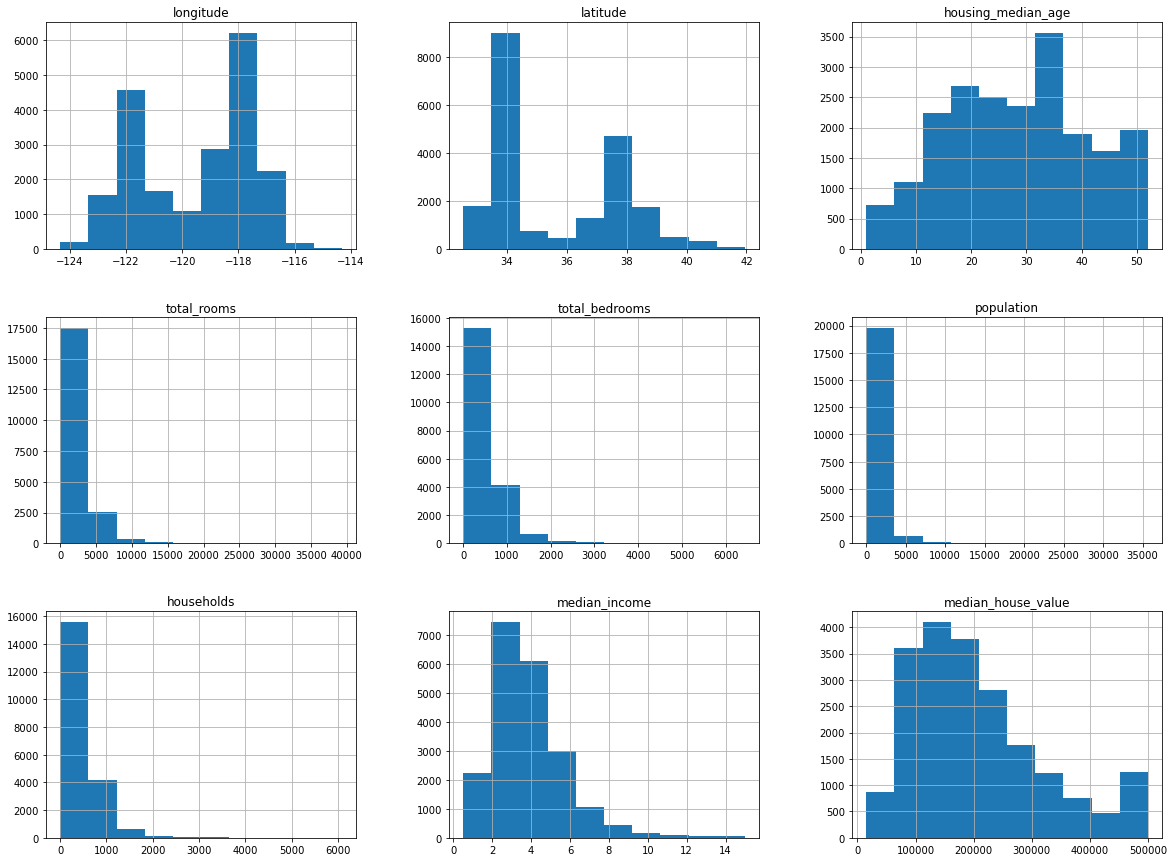

In [7]:
## to get a taste of data let's plot our numerical data as histograms with the help of matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
data.hist(figsize=(20,15))
plt.show()

After plotting histograms for all numerical data we can say:

1- Median income is scaled and capped between 0.5 and 15, it's in thousand of dollars as data collectors said.

2- The target variable: median house value is capped in 500 000USD. which means that the ML algorithms may learn that median house prices cannot go over 500k USD. We should check with the clients(output users) if they need to predict some median price over 500k USD or not.

3- Features have different scales => we need feature scaling

4- Many histo are **tail heavy** which means that they go to zero slower than an exponential distribution, which can be difficult for some algorithms to find patterns in data. So we will have to transform them into a more bell-shaped distributions

## Splitting data into train/test

Splitting data using scikitlearn function
We pass our dataframe, the size of test size and a random number which guarantee that whenever running our code we will get the same train and test data so that we can avoid that our model sees the whole dataset!!

In [8]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(data, test_size=0.2, random_state=42)
train.shape

(16512, 10)

In [9]:
test.shape

(4128, 10)

For now we've randomly splitted our data into trainning and testing set which is fine if your dataset is large enough.

But in some cases you run the risk of introducing **sampling bias**. Which mean that the training data doesn't reflect the actual environment that the model will be running in.

For example you are building a self-driving car model, and you've just trained it on daylight video, so when you launched into production it can't drive in nighttime.

In our case after chatting with real-estate experts, we recognize that **median income** feature is the most important attribute to predict **median housing prices**. So we should make sure that the test set is representative of different ranges of **median income**.

<AxesSubplot:>

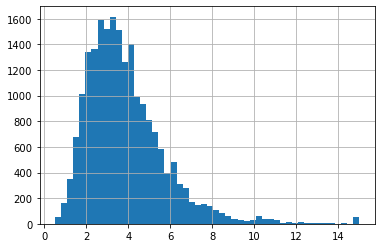

In [10]:
data["median_income"].hist(bins=50)

Since Median income is continuous feature we need to create an income_category feature. From the hist above most median incomes are clustered between 1.5 and 6.

Let's create 5 categories of **median income** labeled from 1 to 5

In [11]:
import numpy as np
data["income_cat"]=pd.cut(data['median_income'],bins=[0,1.5,3,4.5,6,np.inf],labels=[1,2,3,4,5])

In [12]:
data["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

<AxesSubplot:>

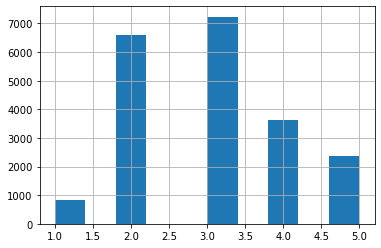

In [13]:
data["income_cat"].hist()

In [14]:
# the percentage of each categorie in data
(data["income_cat"].value_counts()/data["income_cat"].shape[0])*100

3    35.058140
2    31.884690
4    17.630814
5    11.443798
1     3.982558
Name: income_cat, dtype: float64

In [19]:
# we should respect this ratios while splitting train/test
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["income_cat"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

In [21]:
# strat_train_set
(strat_train_set["income_cat"].value_counts()/strat_train_set["income_cat"].shape[0])*100

3    35.059351
2    31.885901
4    17.629603
5    11.440165
1     3.984981
Name: income_cat, dtype: float64

In [22]:
(strat_test_set["income_cat"].value_counts()/strat_test_set["income_cat"].shape[0])*100

3    35.053295
2    31.879845
4    17.635659
5    11.458333
1     3.972868
Name: income_cat, dtype: float64

**As we can see the ratio of each incom cat is the almost the same in test and train sets.**

Now let's drop the income_cat columns as we have finished splitting test/train.

In [23]:
for data_set in (strat_test_set,strat_train_set):
    data_set.drop("income_cat",axis=1,inplace=True)